In [1]:
#!/usr/bin/env python
# vim: set fileencoding=utf-8 :

__author__ = ' AUTOR: Tomás Sánchez Sánchez-Pastor'

''' RNN Bidireccional en Keras '''


"""Imports: librerias"""
import os
import math
from math import sqrt
import sys
import numpy
import numpy as np
import random
random.seed(0)
import scipy.stats
from pylab import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from time import time

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from keras.initializers import glorot_uniform

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


import pandas as pd  

import tensorflow as tf

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.dates as mdates


##Para cambiar las fuentes
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 'large'
mpl.rcParams['ytick.labelsize'] = 'large'
mpl.rcParams['axes.labelsize'] = 'large'

import matplotlib as mpl
np.set_printoptions(threshold=np.inf)

import pdb # Para depurar
import copy

Using TensorFlow backend.


In [2]:
"""
# Medians Rn222 HallA
mdnRnA=[87.0, 88.0, 112.0, 99.0, 102.0, 86.0, 100.0, 88.0, 75.0, 94.0 ,80.0, 86.0, 76.0, 75.0 ,78.0, 67.0 ,67.0, 79.0 ,54.0, 66.0, 63.0, 60.5, 54.0, 63.0, 65.0, 73.0, 84.0, 70.0, 72.5, 77.0, 74.0, 84.0, 81.0, 81.5, 97.0, 97.0, 92.0, 80.0, 87.0, 90.0, 74.0, 75.0, 78.0, 82.0, 78.0, 75.0, 67.0, 74.0, 89.0, 86.0, 81.0, 85.0, 84.0, 81.0, 79.0, 99.0, 114.0, 94.0, 64.0, 76.0, 69.0, 74.0, 71.0, 79.0, 68.0, 64.0, 62.0, 67.0, 60.0, 64.0, 73.0, 68.0, 60.0, 72.0, 71.0, 71.0, 68.0, 77.0, 67.0, 46.0, 75.0, 86.0, 80.0, 88.0, 85.0, 61.0, 80.0, 98.0, 108.0, 89.0, 68.0, 65.0, 91.0,96.0, 106.5, 108.0, 106.5, 109.5, 104.0, 110.0, 86.0, 85.0, 89.0, 85.0, 71.0, 82.5, 75.0, 83.0, 73.0, 57.0, 55.0, 60.0, 63.0, 66.0, 79.0, 74.0, 81.0, 72.5, 67.0, 79.0, 73.0, 73.0, 70.0, 78.5, 69.0, 69.0, 65.0, 75.0, 72.0, 71.0, 72.5, 82.0, 100.0, 97.0, 97.0, 92.0, 101.0, 102.0, 73.0, 69.0, 72.0, 66.5, 72.0, 65.5, 75.5, 73.0, 63.0, 89.0, 98.0, 69.0 , 84.0, 81.0, 77.0, 65.0, 70.0, 87.0, 74.0, 66.0, 80.0, 69.0, 66.0, 62.0, 67.0, 65.0, 74.0, 77.0, 81.0, 79.0, 65.0, 72.0, 81.0, 70.0, 70.0, 70.0, 79.0, 81.0, 91.0, 84.0,73.5, 99.0, 101.0, 67.0, 76.0, 70.0, 74.0, 73.0, 80.0, 77.0, 104.0, 74.0, 80.0, 80.0, 86.0, 105.0, 97.0, 93.5, 92.0,76.0, 68.0, 56.0, 59.0, 72.0, 68.0, 79.0, 64.0, 71.5, 76.0, 74.0, 59.0, 74.0, 64.0, 68.0, 64.0, 67.0, 70.0, 77.0, 67.0, 71.0, 80.0, 84.0, 83.0, 70.0, 70.0, 95.0, 102.0, 109.0, 88.0, 89.0]
print(len(mdnRnA))
"""

# Medians Rn222 HallA (correcto 52 semanas X 5 años =259 valores)
mdnRnA = np.loadtxt('../mdnRnA.txt', delimiter=',')

print("Length of the dataset: ",len(mdnRnA), "\nTrain_Size: ",0.7*len(mdnRnA), "\nTest_Size: ",int(round(0.3*len(mdnRnA)))  )

# New values 
# It starts first week of July 2018 until 23th Sept 2018 (12 weeks)
newValuesReal=[90, 106, 99, 104, 90, 80, 99, 100, 98, 85, 96, 84]

################ ANN's en Keras ###################
# 
dataset = mdnRnA

Length of the dataset:  316 
Train_Size:  221.2 
Test_Size:  95


In [3]:
sample_size = 4 
ahead = len(newValuesReal)
dataset = np.asarray(dataset)
nepochs=40

In [4]:
assert 0 < sample_size < dataset.shape[0] 

# Aquí ha pasado a array la lista con los datos, saca por pantalla la longitud de los datos de entrenamiento y de los de test
# y comprueba que las dimensiones del dataset son correctas. El algoritmo pasará por los datos 40 veces.
#############################################################################################################################

## Creacion de las muestras a partir del array normalizado ##
X = np.atleast_3d(np.array([dataset[start:start + sample_size] 
    for start in range(0, dataset.shape[0]-sample_size)]))
# La lista comprimida crea ventanas de 52 datos empezando desde 0 hasta 52, lo convierte en array
# y con atleast_3d lo convierte en una matriz tridimensional

In [5]:
y = mdnRnA[sample_size:]
qf = np.atleast_3d([dataset[-sample_size:]]) 

In [6]:
# Separamos en datos de entrenamiento y evaluacion
#test_size = 52
test_size = int(0.3*len(mdnRnA))

trainX, testX = X[:-test_size], X[-test_size:]
trainY, testY = y[:-test_size], y[-test_size:]
print("trainX.shape = ", trainX.shape, "\ntrainY.shape = ", trainY.shape)

nextSteps = np.empty((ahead+1,sample_size,1))
nextSteps[0,:,:]= np.atleast_3d(np.array([dataset[start:start + sample_size] 
    for start in range(dataset.shape[0]-sample_size,dataset.shape[0]-sample_size+1)]))

trainX.shape =  (218, 4, 1) 
trainY.shape =  (218,)


In [12]:
# Convolutional model:
def NN():
    model = Sequential()
    neurons = [64, 32]
    model.add(Conv1D(filters=neurons[0], kernel_size=3, activation='relu', input_shape=(sample_size, 1)))
    #model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(neurons[0], activation='relu'))
    model.add(Dense(neurons[1], activation='relu'))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam", metrics=["acc"])
    model.summary()
    history = model.fit(trainX, trainY, epochs=35, batch_size=10, verbose=0, validation_data=(testX, testY)) 
    pred = model.predict(testX)
    return history, pred, model

In [13]:
history, pred, model = NN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 2, 64)             256       
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 10,625
Trainable params: 10,625
Non-trainable params: 0
_________________________________________________________________


In [14]:
acc_train = np.average(history.history["acc"])
acc_test = np.average(history.history["val_acc"])
print("Train Accuracy: ", acc_train, "\nTest Accuracy:  ", acc_test)

Train Accuracy:  0.03656618669336151 
Test Accuracy:   0.0416413380518148


In [15]:
# Calcular ECM y EAM
testScoreECM = mean_squared_error(testY, pred)
print('ECM: %.4f' % (testScoreECM))

testScoreEAM = mean_absolute_error(testY, pred)
print('EAM: %.4f' % (testScoreEAM))

ECM: 101.9945
EAM: 8.0033


In [16]:
ECM = []
EAM = []
for it in range(10):
    print('Iteration ', it)
    history, pred, model= NN()
    ECM.append(mean_squared_error(testY, pred))
    EAM.append(mean_absolute_error(testY, pred))
print(':ECM: %.4f' % (np.mean(ECM)))
print(':EAM: %.4f' % (np.mean(EAM)))

Iteration  0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 2, 64)             256       
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 10,625
Trainable params: 10,625
Non-trainable params: 0
_________________________________________________________________
Iteration  1
_________________________________________________________________
Layer (type)                 Output Shape     

Iteration  9
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 2, 64)             256       
_________________________________________________________________
flatten_12 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_35 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 33        
Total params: 10,625
Trainable params: 10,625
Non-trainable params: 0
_________________________________________________________________
:ECM: 100.5604
:EAM: 7.9235


In [52]:
''' predecir el futuro. '''
newValues = np.zeros(ahead)
temp=np.zeros(sample_size)

for i in range(ahead):
    #print('ahead',i)
    #print('prediccion ', model.predict(nextSteps[None,i,:]), scaler.inverse_transform(model.predict(nextSteps[None,i,:])) )
    temp=nextSteps[i,1:,:]
    #print(temp, len(temp))
    temp = np.append(temp,model.predict(nextSteps[None,i,:]), axis=0)
    newValues[i] = model.predict(nextSteps[None,i,:])
    #print(temp, len(temp))

    #print(nextSteps[i,:,:])
    nextSteps[i+1,:,:]= temp
    #print(nextSteps[i+1,:,:])

# Calcular ECM y EAM for ahead values
#print('ECM ahead: %.4f' % (mean_squared_error(newValuesReal, newValues)))
#print('EAM ahead: %.4f' % (mean_absolute_error(newValuesReal, newValues)))

#print(model.output_shape)
#print(model.summary())
#print(model.get_config())


startday = pd.datetime(2013, 7, 1)
startdaypred = pd.datetime(2013, 7, 1) + 7*pd.Timedelta( len(mdnRnA)-len(pred), unit='D')
startdayahead = pd.datetime(2013, 7, 1) + 7*pd.Timedelta( len(mdnRnA), unit='D')
#print(startday,startdaypred,startdayahead)

In [53]:
fechas = pd.date_range(startday, periods=len(mdnRnA), freq='W').union(pd.date_range(startdaypred, periods=len(pred), freq='W'))
#print(fechas.strftime("%Y-%m-%d").tolist())
#np.savetxt('fechas.txt', fechas.strftime("%Y-%m-%d").tolist(), delimiter=',', fmt='%s')

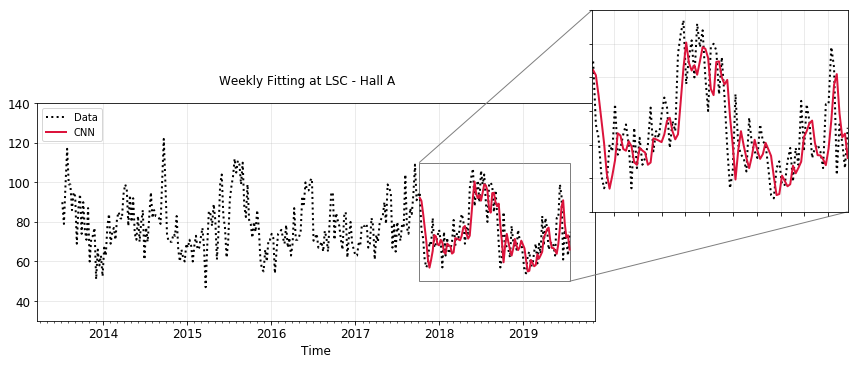

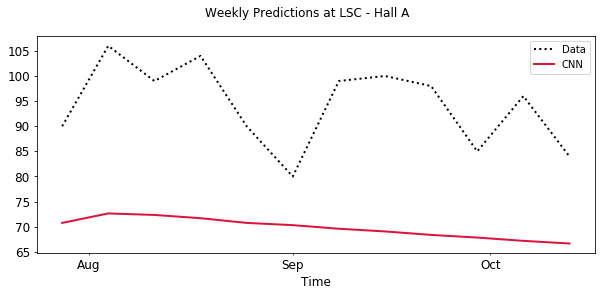

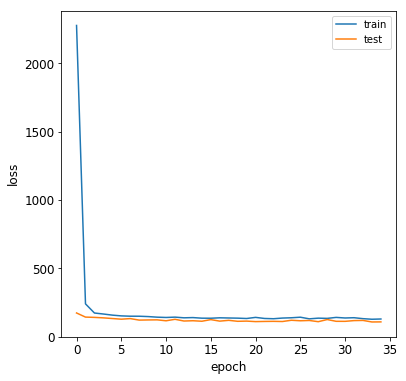

In [56]:
### Plotting ###
# general plot
### Plotting ###
# general plot
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,4))
plt.figure(1)
xaxis = ax.get_xaxis()
#ax.xaxis.grid(b=True, which='minor', color='0.90', linewidth=0.6)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
#ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))

ax.plot(pd.date_range(startday, periods=len(mdnRnA), freq='W'), mdnRnA, linewidth=2, color='k', linestyle=':') 
ax.plot(pd.date_range(startdaypred, periods=len(pred), freq='W'), pred, linewidth=2, linestyle='-',color='crimson')
plt.xlabel('Time')
plt.grid(True, alpha=.3)
ax.legend(['Data', 'CNN'], loc='upper left')
plt.ylim([30, 140])

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
axins = zoomed_inset_axes(ax, 1.7, loc='lower left', bbox_to_anchor=(640,140))
axins.plot(pd.date_range(startday, periods=len(mdnRnA), freq='W'), mdnRnA, linewidth=2, color='k', linestyle=':') 
axins.plot(pd.date_range(startdaypred, periods=len(pred), freq='W'), pred, linewidth=2, linestyle='-',color='crimson')
axins.set_xlim('2017-10-05', '2019-07-21')
plt.grid(True, alpha=.3)
axins.set_ylim(50, 110)

plt.xticks(visible=False)
plt.yticks(visible=False)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.suptitle('Weekly Fitting at LSC - Hall A')
#plt.savefig('./fitting_CNN_weekly_D'+str(neurons[0])+'D'+str(neurons[1])+'_D1_e50_b10_ss52_ts52.eps', 
#            bbox_inches='tight')

# ahead plot
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,4))# 
plt.figure(2)
xaxis = ax.get_xaxis()
#ax.xaxis.grid(b=True, which='minor', color='0.90', linewidth=0.6)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))

ax.plot(pd.date_range(startdayahead, periods=len(newValuesReal), freq='W'), newValuesReal, color='k', linestyle=':',
        linewidth=2)
ax.plot(pd.date_range(startdayahead, periods=len(newValues), freq='W'), newValues, linestyle='-', 
        color='crimson', linewidth=2)
ax.legend(['Data', 'CNN'], loc='upper right')
plt.xlabel('Time')
plt.suptitle('Weekly Predictions at LSC - Hall A')
#plt.savefig('./detailedprediction_ANN_weekly_D'+str(neurons[0])+'D'+str(neurons[1])+'_D1_e50_b10_ss52_ts52.eps')

# summarize history for loss
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,6))# 6,6
plt.figure(3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#ax.set_yscale("log")
#plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
#plt.savefig('./loss_ANN_weekly_D'+str(neurons[0])+'D'+str(neurons[1])+'_D1_e50_b10_ss52_ts52.eps')

plt.show()

In [ ]:
# fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,4))
# plt.figure(1)
# xaxis = ax.get_xaxis()
# #ax.xaxis.grid(b=True, which='minor', color='0.90', linewidth=0.6)
# ax.xaxis.set_major_locator(mdates.YearLocator())
# ax.xaxis.set_minor_locator(mdates.MonthLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
# #ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))

# ax.plot(pd.date_range(startdaypred, periods=len(pred), freq='W'), 
#         mdnRnA[len(mdnRnA)-len(pred):len(mdnRnA)], linewidth=1, color='k') 
# ax.plot(pd.date_range(startdaypred, periods=len(pred), freq='W'), pred, linewidth=3, linestyle=':',color='b')
# ax.legend(['Data', 'CNN'])
# plt.xlabel('Time')
# #ax.plot(pd.date_range(startdayahead, periods=len(newValues), freq='W'), newValues, linestyle='--', color='b', linewidth=1 )
# #ax.plot(pd.date_range(startdayahead, periods=len(newValuesReal), freq='W'), newValuesReal, color='g', linewidth=1 )

# plt.suptitle('Weekly Predictions at LSC - Hall A')
# plt.show()

In [ ]:
# ### Plotting ###
# # general plot
# fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,4))
# plt.figure(1)
# xaxis = ax.get_xaxis()
# #ax.xaxis.grid(b=True, which='minor', color='0.90', linewidth=0.6)
# ax.xaxis.set_major_locator(mdates.YearLocator())
# ax.xaxis.set_minor_locator(mdates.MonthLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
# #ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))

# ax.plot(pd.date_range(startday, periods=len(mdnRnA), freq='W'), mdnRnA, linewidth=1, color='k') 
# ax.plot(pd.date_range(startdaypred, periods=len(pred), freq='W'), pred, linewidth=2, linestyle=':',color='b')
# plt.xlabel('Time')
# plt.ylim([30, 140])

# from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
# axins = zoomed_inset_axes(ax, 1.7, loc='lower left', bbox_to_anchor=(640,140))

# axins.plot(pd.date_range(startday, periods=len(mdnRnA), freq='W'), mdnRnA, linewidth=1, color='k') 
# axins.plot(pd.date_range(startdaypred, periods=len(pred), freq='W'), pred, linewidth=2, linestyle=':',color='b')

# axins.set_xlim('2017-01-01', '2018-06-17')
# axins.set_ylim(50, 110)

# plt.xticks(visible=False)
# plt.yticks(visible=False)

# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# plt.suptitle('Weekly Predictions at LSC - Hall A')
# #plt.savefig('./prediction_ANN_weekly_D'+str(neurons[0])+'D'+str(neurons[1])+'_D1_e50_b10_ss52_ts52.eps')
# plt.show()

In [ ]:
# pd.date_range(startdaypred, periods=len(pred), freq='W')

In [ ]:
acctrain = []
acctest = []
for it in range(1, 100, 5):
    print("epochs = ", it)
    history = model.fit(trainX, trainY, epochs=it, batch_size=10, verbose=0, validation_data=(testX, testY)) 
    acc_train = np.average(history.history["acc"])
    acctrain.append(acc_train)
    acc_test = np.average(history.history["val_acc"])
    acctest.append(acc_test)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.plot(range(1, 100, 5), acctrain, 'o')
ax.plot(range(1, 100, 5), acctest, 'o')
plt.xlabel('$n_{epochs}$')
plt.ylabel('$acc$')
plt.legend(['Train', 'Test'])